# <center>Final project</center> 

***

## Students

* Team: `8`
* Students: `Matyas Lustig, Aurélien Pomini, David Salathé, Justine Weber`
* Dataset: `Flight Routes`

## Motivation

***

## Imports

In [115]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy
from scipy import sparse

from mpl_toolkits.basemap import Basemap
# if you don't have it installed run : conda install -c anaconda basemap

import sys
from random import randint

In [2]:
# Plotting tools

# For adapting colorbar size
from mpl_toolkits.axes_grid1 import make_axes_locatable

***

## Tool functions

In [3]:
def unweight(matrix) :
    assert(isinstance(matrix, np.ndarray))
    assert(matrix.shape[0] == matrix.shape[1])
    uw = matrix.copy()
    uw[uw>0] = 1
    return uw

In [4]:
def features_from_IATA(features, active):
    """ Returns dataset of targeted airports,
    Given the list of IATA we want
    
    features : dataframe containing a columns 'IATA'
    active : dictionnary where the values are 'IATA' codes
    """
    select_feat = features[features['IATA'].isin(active.values())]
    select_feat = select_feat.reset_index(drop=True)
    
    return select_feat

***

## Loading / cleaning the data  & Building the network

### Description 
TODO Explain what we load as Data, and how we construct the network in general <br>
"We only keep the active airports in our graph, ie. those connected to something ie. listed in routes"

In [5]:
# Load airports dataset to get the features for each node
airports_ds = pd.read_csv('data/airports.dat', header = None, encoding='utf-8', names = ["Airport ID", "Name"
                                                                                         , "City", "Country", 
                              "IATA", "ICAO", "Latitude", "Longitude", "Altitude", 
                              "Timezone", "DST", "Tz db time zone", "Type", "Source"])

# Load routes dataset to get the nodes and edges that we will use to create the network
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8', engine='python', 
                     names = ["Airline", "Airline_ID", "Source_airport", "Source_airport_ID", 
                              "Destination_airport", "Destination_airport_ID", "Codeshare", "Stops", "Equipment"]
                     , na_values=['\\N'])

# Take all airports ID which are listed in the routes dataset, either as destination or as source
airports = pd.concat([routes["Source_airport_ID"],routes["Destination_airport_ID"]], axis=0)
airports = airports.drop_duplicates()

# Take lines of the airport dataset, corresponding to the above airports (ie. listed in routes)
features = airports_ds[airports_ds['Airport ID'].isin(airports)]

features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)


print("Number of airports in the airports.dat file:", len(airports_ds))
print("Number of \"active\" airports in the routes.dat file:", len(features))
features.head(4)

Number of airports in the airports.dat file: 7184
Number of "active" airports in the routes.dat file: 3186


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,0
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,1
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,2
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,3


TODO Explain how we construct adjacency matrix (weighted and unweighted and why both are useful) <br>
Explain what is active_idx and why we need it : it is a "memory" for the indices of the airports that we are still tracking. This enables to know which airport the lines of the adjacency matrices correspond to, and for example to get the location of a certain node on the world map. <br><br>

I haven't decided yet how I want to do this : 
- either we use active_idx : elements are 1 for the actives indices and 0 for the others > but it doesn't give directly the position of the airport in the adjacency matrix
- either we use active_idx2 : elements and the position of the airports in the adjacecncy matrix (indices are the indices in features dataframe
- either we use active_idx3 : elements are the IATA and indices are thes indices in the adjacency matrxi (CAREFUL: it is the otherway than option 1 and 2)

In [6]:
# Create dataframe of source and destination IATA for each route
idx_IATA = features[['IATA', 'newidx']]
routes_srcdest = routes[['Source_airport', 'Destination_airport']]

# Left join because we preserve the airports from routes, even if you don't have features on them
idx_src = routes_srcdest.merge(right=idx_IATA, how='left', left_on='Source_airport', right_on='IATA')
idx_src_dest = idx_src.merge(right=idx_IATA, how='left', left_on='Destination_airport', right_on='IATA',
                             suffixes=['_src', '_dest']).drop(columns=["IATA_src", "IATA_dest"])

In [7]:
# Build the general adjacency matrix
n_nodes = len(features)

active_l = ["" for x in range(n_nodes)]

adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
adjacency_uw = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in idx_src_dest.iterrows():

    if pd.isnull(row.newidx_src) or pd.isnull(row.newidx_dest):
        continue
    i, j = int(row.newidx_src), int(row.newidx_dest)
    
    active_l[i] = row.Source_airport
    active_l[j] = row.Destination_airport
    
    adjacency_uw[i, j] = 1
    
    adjacency[i, j] = adjacency[i, j] + 1

#adjacency.max()
active = np.asarray(active_l)

TODO Explain here what we do : "clean" the network by removing the routes which are connected to nothing, due to NULL elements in dataset

In [8]:
a = adjacency.sum(axis=1)
b = adjacency.sum(axis=0)

zero_in = np.argwhere(a==0)
zero_out = np.argwhere(b==0)

print("The following values are indices of airports which are connected to nothing :")
no_connection = []

for value in zero_in :
    if np.isin(value[0],zero_out):
        no_connection.append(value[0])

# Check : the table no_connection should exactly contain the elements which 
# are represented with an empty string in active_l 
assert(no_connection == [i for i, val in enumerate(active_l) if val == ""]) 
   
print(no_connection)
print("\nTheses airports are the following:")
print(features.loc[features['newidx'].isin(no_connection), ['IATA', 'City', 'Country']])

The following values are indices of airports which are connected to nothing :
[1522, 1523, 2643, 3027, 3029, 3040, 3088]

Theses airports are the following:
     IATA              City         Country
1522  RJA       Rajahmundry           India
1523  TIR          Tirupeti           India
2643  LPS             Lopez   United States
3027  AKI             Akiak   United States
3029  TKJ               Tok   United States
3040  SPB  Charlotte Amalie  Virgin Islands
3088  AGM      Angmagssalik       Greenland


In [9]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DROPS COLUMNS EACH TIME
features = features.drop(features.index[no_connection])
features = features.set_index(pd.Series(range(len(features))))
features = features.assign(newidx=pd.Series(range(len(features))).values)

In [10]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ROWS & COLUMNS EACH TIME
adjacency = np.delete(adjacency, no_connection, 0)
adjacency = np.delete(adjacency, no_connection, 1)
adjacency_uw = np.delete(adjacency_uw, no_connection, 0)
adjacency_uw = np.delete(adjacency_uw, no_connection, 1)

In [11]:
# CAREFULL, DON'T RUN THIS CELL SEVERAL TIMES OTHERWISE IT DELETES ELEMENTS EACH TIME
active = np.delete(active, no_connection)

In [12]:
active = dict(enumerate(active))

TODO Explain the final adjacency matrices (why we set diag to zeor, why we symmetrize and how we do it, ie. for the weighted symmetrized matrix what does each weight represent > the total number of airlines going through this edge, counted twice if in both ways)

In [13]:
# Set diagonals to zero to remove self loops
adjacency[np.diag_indices_from(adjacency)] = 0
adjacency_uw[np.diag_indices_from(adjacency_uw)] = 0

In [14]:
# Build the symmetric matrices (weighted and unweighted)
adjacency_sym = adjacency + adjacency.T
#adjacency_uw_sym = adjacency_sym
#adjacency_uw_sym[adjacency_uw_sym>0] = 1
adjacency_uw_sym = unweight(adjacency_sym)

In [15]:
# the adjacency matrix we use for the project : symmetric and weighted
adj = adjacency_sym

TODO : Write something

In [16]:
# Extracting Largest connected component

# Create graph in networkx
G = nx.from_numpy_matrix(adj)

nx.set_node_attributes(G, active, "IATA")
#nx.set_node_attributes(G, types_dict, "type")

# Extract largest connected component
all_comp = nx.connected_component_subgraphs(G)

# all_comp_nodes is the list of nodes indices for each component
all_comp_nodes = nx.connected_components(G)

# create a list of indices of nodes which are not in the largest component
aside_nodes = []
for nodes in all_comp_nodes:
    #print(len(nodes))
    if(len(nodes)!=3154):
        for node in nodes :
            aside_nodes.append(node)

Gc = max(all_comp, key=len)
active_c = nx.get_node_attributes(Gc,"IATA")

# Take the corresponding adjacency matrix
adj_c = np.array(nx.to_numpy_matrix(Gc))
n_nodes_c = nx.number_of_nodes(Gc)

In [17]:
adj_uw_c = unweight(adj_c)
#active_c.shape
#features_c = 

Extract adjacency of largest component either by: <br>
using point 8 of milestone 1 <br>
using nx: create nx graph, extract largest components, find a way to keep track of which nodes belongs to which airports.

***

## Sample part of the graph for interesting insights

Note that here we use the **unweighted** adjacency matrix, i.e. we only take into account the **number of other airports** to which an airport is connected to define it as very connected or poorly connected, and not the number of flights per route.

In [18]:
def sample_by_degree(adj = adj_uw_c, threshold = 0, way='gt') :
    degrees = np.sum(adj, axis = 1)
    if way == 'gt' :
        select_idx = np.where(degrees >= threshold)[0]
        new_adj = np.delete(adj, np.where(degrees < threshold), 0)
    elif way == 'lt' :
        select_idx = np.where(degrees <= threshold)[0]
        new_adj = np.delete(adj, np.where(degrees > threshold),0)
    elif way == 'exact' :
        select_idx = np.where(degrees == threshold)[0]
        new_adj = np.delete(adj, np.where(degrees != threshold),0)
    else :
        raise ValueError("'way' parameter should be either gt or lt or exact," 
                         + "respectively for greater than, less than, or exactly the threshold")
    
    airports = features.index[select_idx].values
    new_deg = np.sum(new_adj, axis = 1)
    print(new_adj.shape[0])
    
    return new_adj, new_deg, airports

### Very connected (deg >= 20)

In [19]:
adj_gt20, deg_gt20, airports_gt20 = sample_by_degree(threshold = 20, way = 'gt')
#adjacency_csr = sparse.csr_matrix(adj_gt20)
#degree_matrix_csc = sparse.diags(deg_gt20, format = "csc")

451


### Very very connected (deg >= 170)

In [20]:
adj_gt170, deg_gt170, airports_gt170 = sample_by_degree(threshold = 170, way = 'gt')
features.iloc[airports_gt170,:].head(adj_gt170.shape[0])

12


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
191,340,Frankfurt am Main International Airport,Frankfurt,Germany,FRA,EDDF,50.033333,8.570556,364,1,E,Europe/Berlin,airport,OurAirports,191
196,346,Munich International Airport,Munich,Germany,MUC,EDDM,48.353802,11.786100,1487,1,E,Europe/Berlin,airport,OurAirports,196
255,507,London Heathrow Airport,London,United Kingdom,LHR,EGLL,51.470600,-0.461941,83,0,E,Europe/London,airport,OurAirports,255
282,580,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.763890,-11,1,E,Europe/Amsterdam,airport,OurAirports,282
628,1382,Charles de Gaulle International Airport,Paris,France,CDG,LFPG,49.012798,2.550000,392,1,E,Europe/Paris,airport,OurAirports,628
770,1701,Atatürk International Airport,Istanbul,Turkey,IST,LTBA,40.976898,28.814600,163,3,E,Europe/Istanbul,airport,OurAirports,770
1010,2167,Zahedan International Airport,Zahedan,Iran,ZAH,OIZH,29.475700,60.906200,4564,3.5,E,Asia/Tehran,airport,OurAirports,1010
1635,3355,Canberra International Airport,Canberra,Australia,CBR,YSCB,-35.306900,149.195007,1886,10,O,Australia/Sydney,airport,OurAirports,1635
1793,3653,Austin Straubel International Airport,Green Bay,United States,GRB,KGRB,44.485100,-88.129601,695,-6,A,America/Chicago,airport,OurAirports,1793
1802,3673,Austin Bergstrom International Airport,Austin,United States,AUS,KAUS,30.194500,-97.669899,542,-6,A,America/Chicago,airport,OurAirports,1802


### Very not connected (deg <= 10)

In [21]:
# Maybe not so useful
adj_lt1, deg_lt1,airports_lt1  = sample_by_degree(threshold = 1, way = 'lt')
#adjacency_csr = sparse.csr_matrix(adj_lt10)
#degree_matrix_csc = sparse.diags(deg_lt10,format = "csc")
features.iloc[airports_lt1,:].head(5)

697


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz db time zone,Type,Source,newidx
9,10,Thule Air Base,Thule,Greenland,THU,BGTL,76.531197,-68.703201,251,-4,E,America/Thule,airport,OurAirports,9
10,11,Akureyri Airport,Akureyri,Iceland,AEY,BIAR,65.660004,-18.072701,6,0,N,Atlantic/Reykjavik,airport,OurAirports,10
11,12,Egilsstaðir Airport,Egilsstadir,Iceland,EGS,BIEG,65.283302,-14.401400,76,0,N,Atlantic/Reykjavik,airport,OurAirports,11
12,15,Ísafjörður Airport,Isafjordur,Iceland,IFJ,BIIS,66.058098,-23.135300,8,0,N,Atlantic/Reykjavik,airport,OurAirports,12
21,31,Brandon Municipal Airport,Brandon,Canada,YBR,CYBR,49.910000,-99.951897,1343,-6,A,America/Winnipeg,airport,OurAirports,21


## Plotting tests

In [22]:
# Saving all the latitudes and longitudes in matrices
#nb_airpt = features[active].shape[0]
nb_airpt = n_nodes_c

features_c = features_from_IATA(features, active_c)

lats_airpt = np.zeros(nb_airpt)
lons_airpt = np.zeros(nb_airpt)

connectivity = np.sum(adj_uw_c, axis = 1)

for idx, row in features_c.iterrows():
    lats_airpt[idx] = row['Latitude']
    lons_airpt[idx] = row['Longitude']

In [107]:
def plot_map(signal, scale_size=1, alpha_=0.6, colors='Reds', edges=False, adapt_size=True, legend="", 
            nodes_size_legend=False, nodes_size_legend_array=[]):
    
    assert(len(signal)==len(features_c))
           
    # Plot of the mondial map
    plt.figure(figsize=(16,12))
    mymap = Basemap(projection='cyl')

    mymap.drawmapboundary(fill_color='silver')
    mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
    mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
    mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


    x_lons, y_lats = mymap(lons_airpt, lats_airpt)
    
    if adapt_size :
        size = signal
    else :
        size = 1
    
    mymap.scatter(x_lons, y_lats, marker='o', s=size*scale_size, zorder=5, alpha=alpha_, 
                  c = signal, cmap=colors)

    # plot edges
    if edges :
        for i in range(nb_airpt):
            for j in range(i):
                if (adj_c[i,j]>0) :
                    mymap.plot([x_lons[i], x_lons[j]], [y_lats[i], y_lats[j]], linewidth=1, color='w', 
                               linestyle='solid', alpha = 0.1)
    
    # create colorbar and legend
    plt.colorbar(label=legend,fraction=0.025, pad=0.04)
    
    if nodes_size_legend :
        if len(nodes_size_legend_array) == 0:
            raise ValueError("Parameters node_size_legend and node_size_legend_array must match." +
                             " If node_size_legend is set True, then node_size_legend_array must be non empty")
            return
        else :
            for a in nodes_size_legend_array:
                plt.scatter([], [], c='k', alpha=0.5, s=a, label= str(a))
            
            plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left')
    else :
        if len(nodes_size_legend_array) != 0:
            print("Value of parameter nodes_size_legend is set at False by default." +
                  " Parameter node_size_legend_array is therefore ignored.")
    

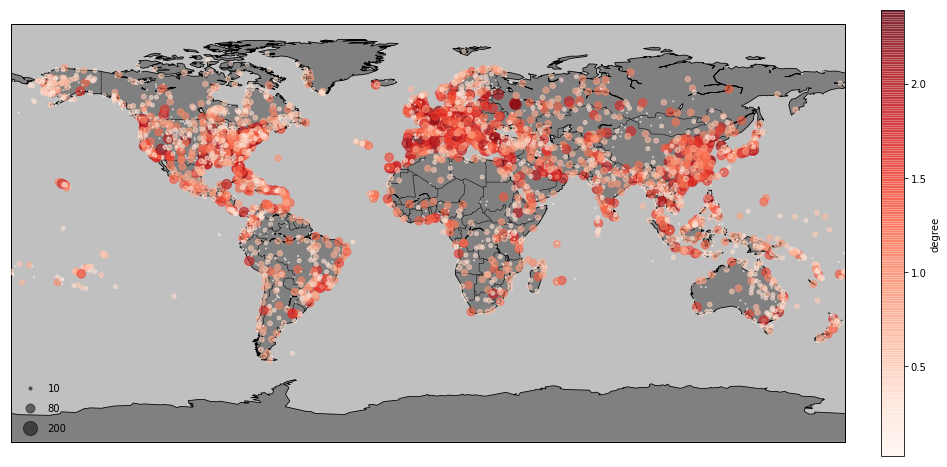

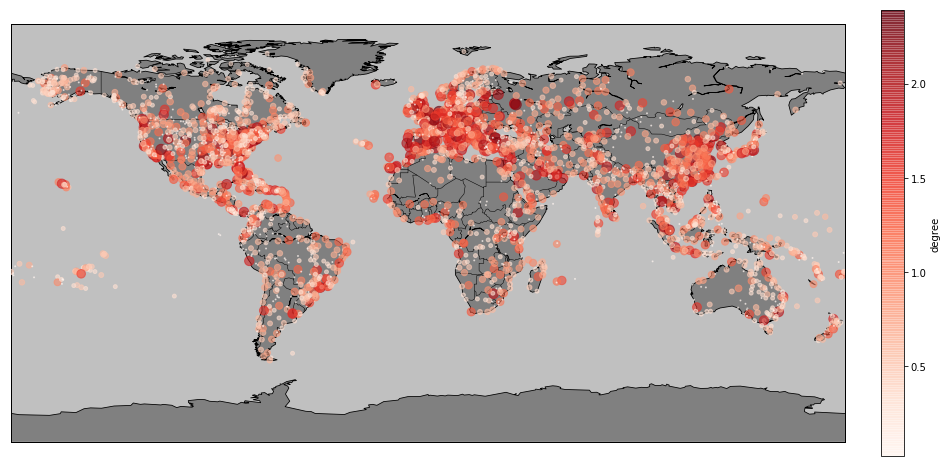

In [108]:
# Plot of the mondial map

highlight = np.log10(connectivity+0.05)
plot_map(highlight, scale_size=50, legend="degree", nodes_size_legend = True,
         nodes_size_legend_array = [10, 80, 200])
plot_map(highlight, scale_size=50, legend="degree", nodes_size_legend = False)

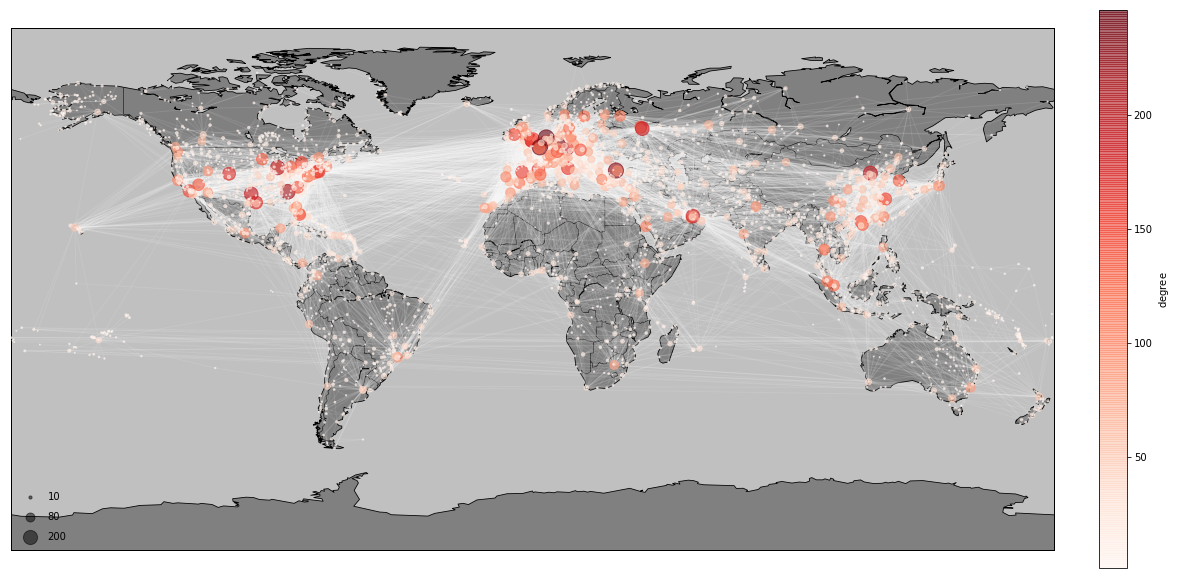

In [106]:
# Plot of the mondial map
fig = plt.figure(figsize=(20, 20))
mymap = Basemap(projection='cyl')

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


x_lons, y_lats = mymap(lons_airpt, lats_airpt)

highlight2 = connectivity

for i in range(nb_airpt):
    for j in range(i):
        if (adj_c[i,j]>0) :
            mymap.plot([x_lons[i], x_lons[j]], [y_lats[i], y_lats[j]], linewidth=1, color='w', 
                       linestyle='solid', alpha = 0.1)

mymap.scatter(x_lons, y_lats,latlon=True, marker='o', s=highlight2, zorder=5, alpha=0.6, 
              c=highlight2, cmap='Reds')

plt.colorbar(label=r'${\rm degree}$',fraction=0.025, pad=0.04)
#plt.clim(0, 250)

# make legend with dummy points
for a in [10, 80, 200]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label= str(a))

plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');


plt.show()

## Creates labels

In [26]:
# 1. South-North
# 2. Continent
# 3. Laplacian clustering
# 4. Degree of nodes (importance of airports)
# 5. use you imagination!

In [27]:
# build solid emebedding: eg degree > 20
# plot signal on it and check 

In [28]:
# Build an embedded version in 2d
# build the clusters with sk-learn (with 3 or 6, see correction)
# Put signals and see how it brights the clustered plot
# and try to recover the same plot (with colors) with a good label (signal) > try several

# Small tips:
# try an equivalent of seaborn for plots
# (...)

# Our orininality will be on good choice of labels!

In [29]:
# Do something with airlines ?
# Keep only direct flights ("stops"=0)

In [30]:
# SUBJECT IDEA
# How to select the x airports to progagpate an illness most rapidly/efficiently

In [31]:
def continent_convert(c):
    # E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown)
    switcher = {
        'E' : 1,
        'A': 2,
        'S': 3,
        'O': 4,
        'Z': 5,
        'N': 6,
        'U': 0
    } 
    return switcher.get(c, "Invalid label")

In [32]:
north_south = features_c["Latitude"].apply(lambda x: -1 if x < 0 else 1)
continent = features_c["DST"].apply(continent_convert)

In [33]:
def size_convert(c):
    switcher = {
        "large_airport" : 30, 
        "medium_airport" : 10, 
        "small_airport": 5, 
        "seaplane_base" : 3, 
        "closed" : 2, 
        "heliport": 1,
        "unknown" : 0
    }
    return switcher.get(c, "Invalid label")

In [34]:
types = pd.read_csv('data/airports_type.csv')
types = types[pd.notnull(types['iata_code'])].set_index('iata_code')["type"]

types_label = []

labels = {"large_airport", "medium_airport", "small_airport", "seaplane_base", "closed", "heliport"}

for v in active_c.values():
    try:
        label = str(types.loc[v])
        if label not in labels:
            label = 'unknown'
    except:
        label = 'unknown'

    types_label.append(size_convert(label))



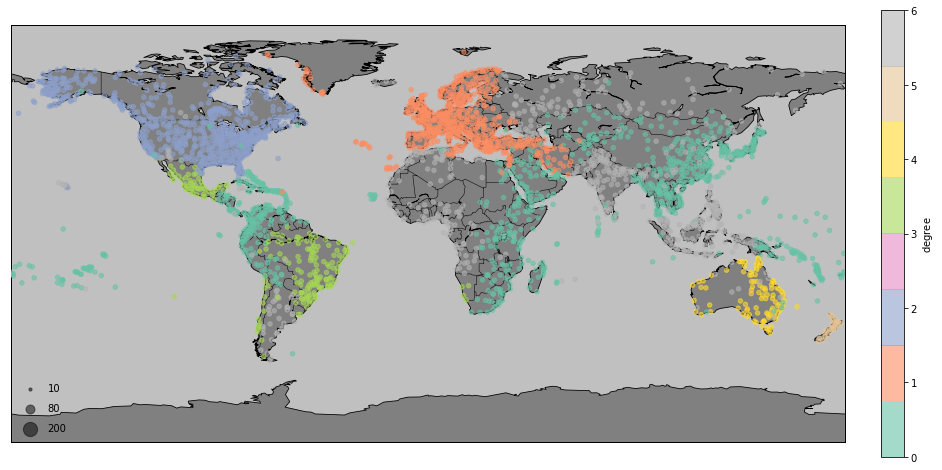

In [36]:
plot_map(continent, colors='Set2', scale_size=20, adapt_size=False, legend="continent")

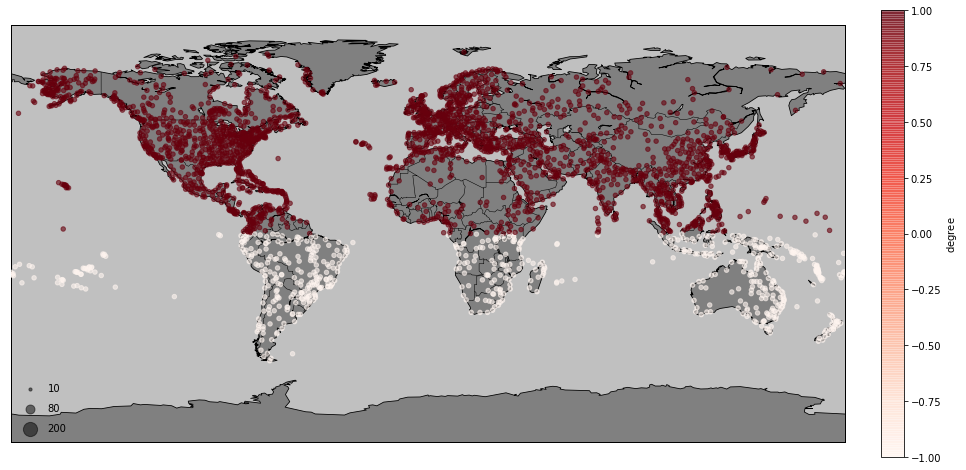

In [37]:
plot_map(north_south, colors='Reds', scale_size=20, adapt_size=False, legend="south/north")

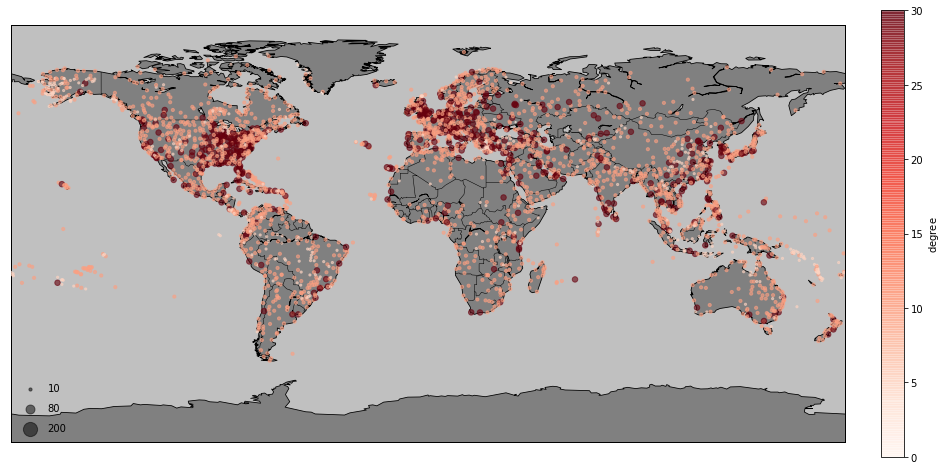

In [38]:
plot_map(types_label, colors = 'Reds', scale_size = 5, adapt_size=True)

## Technical Ideas

In [39]:
# Might be good to create a dictionary of features instead of always keeping this table

### Find hypothesis

## EIGENMAP & ML

In [60]:
# Laplacians using the weighted graph
laplacian_c_comb = sparse.csgraph.laplacian(adj_c, normed=False).astype('float64')
laplacian_c_norm = sparse.csgraph.laplacian(adj_c, normed=True)
laplacian_c = laplacian_c_comb

e_w, U_w = scipy.linalg.eigh(laplacian_c)

In [61]:
# Laplacians using the unweighted graph
laplacian_uw_c_comb = sparse.csgraph.laplacian(adj_uw_c, normed=False).astype('float64')
laplacian_uw_c_norm = sparse.csgraph.laplacian(adj_uw_c, normed=True)
laplacian_uw_c = laplacian_uw_c_comb

e_uw, U_uw = scipy.linalg.eigh(laplacian_uw_c)

In [62]:
e = e_uw
U = U_uw

## Spectral graph theory

### Tool GFT functions

In [63]:
def GFT(x):
    return U.T.dot(x)

def iGFT(x):
    return U.dot(x)

### Filters

Functions

In [64]:
def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    return np.diag(np.linalg.inv(np.identity(n_nodes_c) + t*np.diag(e)))

def rectangle_kernel(e, l_min, l_max):
    f = np.vectorize(lambda x: 1.0 if x >= l_min and x <= l_max else 0.0)
    return f(e)

def graph_filter(x, kernel, **kwargs):    
    return iGFT(GFT(x) * kernel(e=e, **kwargs))

Parameters

In [65]:
t_heat = 0.15
t_inv = 0.35
lmin = 0.0
lmax = 1.1

### Kernel applied to most connected node

In [113]:
def kernel_map(init_signal, scale_size = 100, adapt_size=True, t_heat=t_heat, t_inv=t_inv, lmin=lmin, lmax=lmax, kernels="all") :
    
    if kernels == "all" or kernels == "heat":
        heat = graph_filter(init_signal, heat_kernel, t=t_heat)
        plot_map(heat, scale_size = scale_size, adapt_size=adapt_size)

    if kernels == "all" or kernels == "inverse":
        inverse = graph_filter(init_signal, inverse_kernel, t=t_inv)
        plot_map(inverse, scale_size = scale_size, adapt_size=adapt_size)

    if kernels == "all" or kernels == "rectangle":
        rectangle = graph_filter(init_signal, rectangle_kernel, l_min=lmin, l_max = lmax)
        plot_map(rectangle, scale_size = scale_size, adapt_size=adapt_size)


771


/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


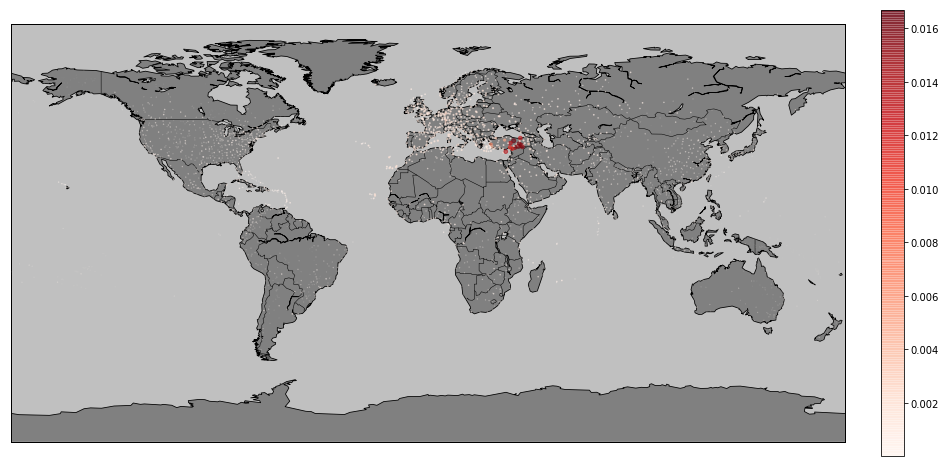

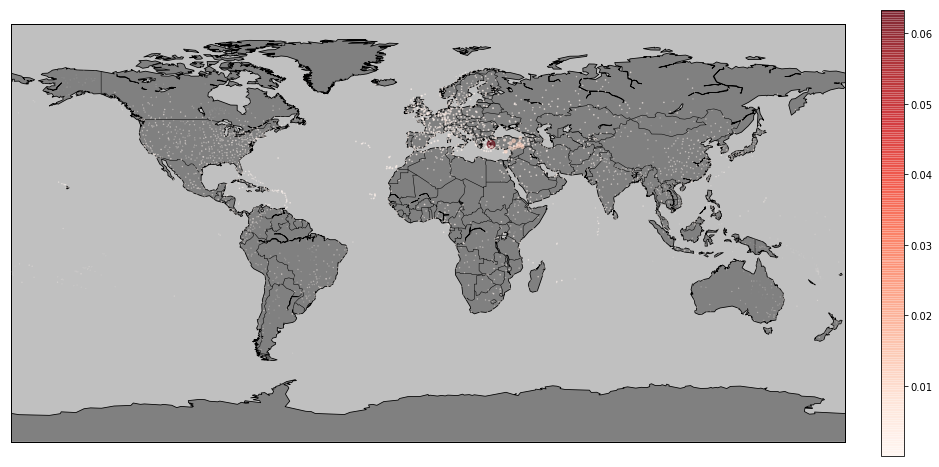

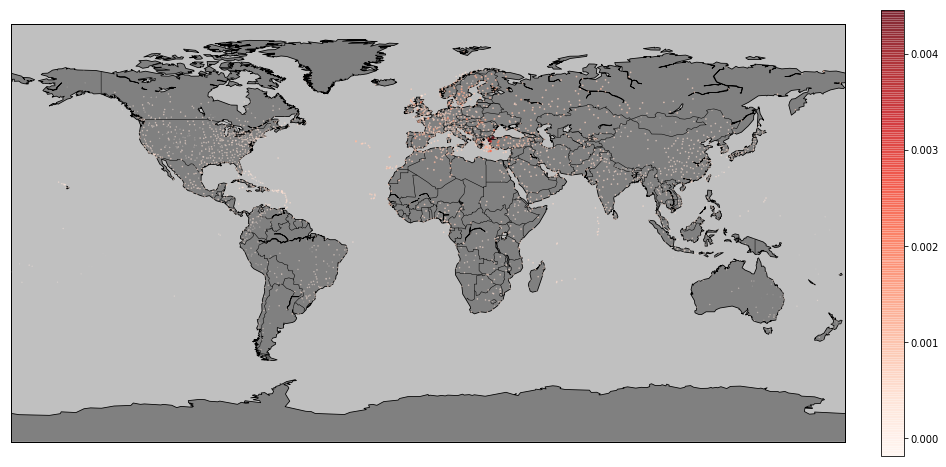

In [136]:
# interesting results for these idx:
# 2909 (all the same)
# 2089 - differents results depending on kernel
# 1272
# 242 - very connected from europe (like frankfor)
# 1377
# 2060 - from states, propagates everywhere
# 3019/3066 - from south-America propagates a lot, not uniformly
# 1056 - Japan
# 678 - from Europe, different given kernels
# 2247 - green land : doesn't propagate at all !!
# 2992 - alaska propagates everywhere - not uniformly

dirac = np.zeros(n_nodes_c)

random_ = randint(0, nb_airpt)
print(random_)
dirac[random_]=1

kernel_map(dirac, scale_size= 1000)

/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


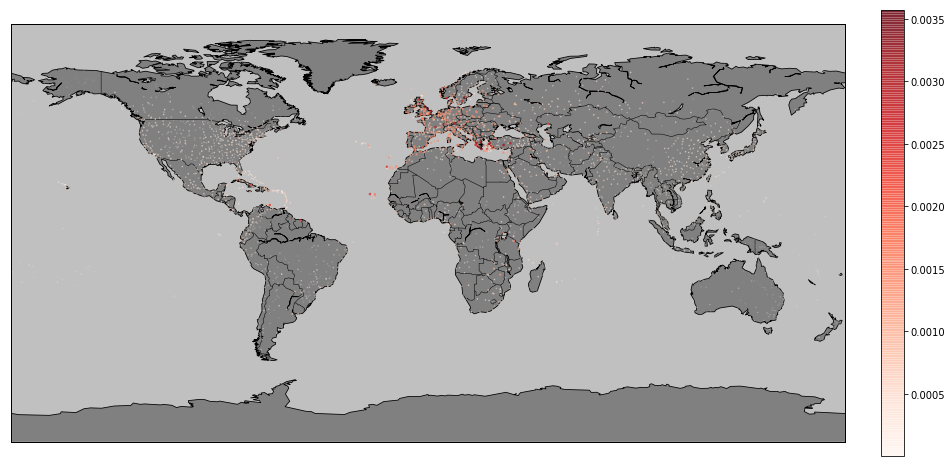

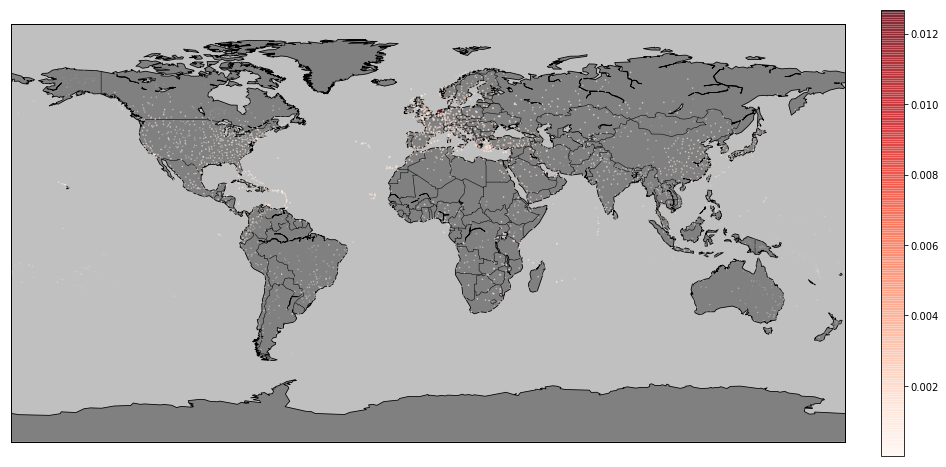

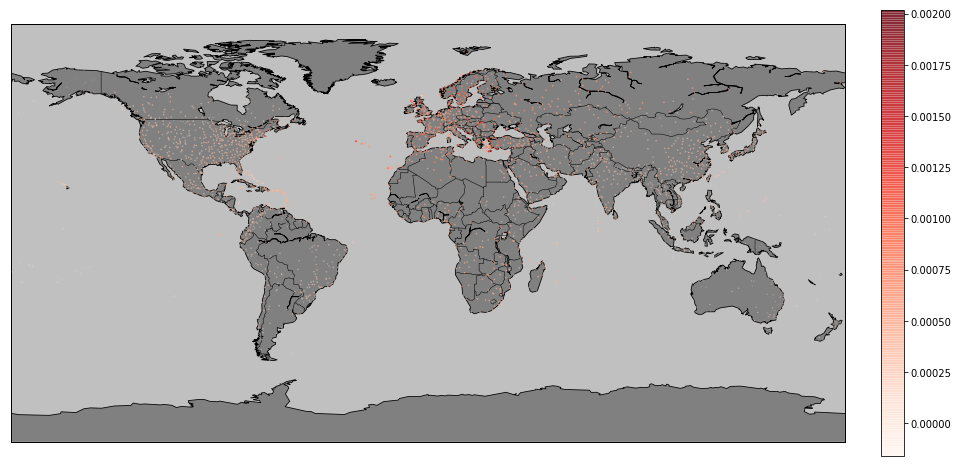

In [137]:
dirac1 = np.zeros(n_nodes_c)

max_connected_node = np.argmax(np.sum(adj_uw_c, axis = 1))

dirac1[max_connected_node]=1

kernel_map(dirac1, scale_size= 1000)

## TESTS

#### Check if airports are correctly placed on the map 

Airport ID                           11258
Name               Saumlaki/Olilit Airport
City                              Saumlaki
Country                          Indonesia
IATA                                   SXK
ICAO                                  WAPI
Latitude                          -7.98861
Longitude                          131.306
Altitude                               218
Timezone                                 9
DST                                      N
Tz db time zone                         \N
Type                               airport
Source                         OurAirports
newidx                                3175
Name: 3150, dtype: object


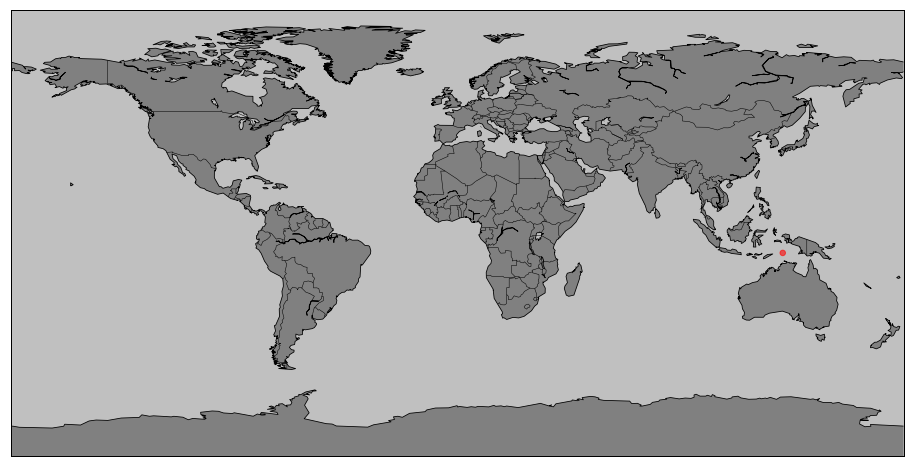

In [41]:
plt.figure(figsize=(16,12))
mymap = Basemap(projection='cyl')

mymap.drawmapboundary(fill_color='silver')
mymap.fillcontinents(color='grey', lake_color='silver', ax=None, zorder=None, alpha=None)
mymap.drawcoastlines(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
mymap.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)


x_lons, y_lats = mymap(lons_airpt, lats_airpt)

# Modify this variable in order to display another airport
idx = 3150

highlight = np.log10(connectivity+0.05)
mymap.scatter(x_lons[idx], y_lats[idx], marker='o', s=highlight*50, zorder=5, alpha=0.6, 
              c = 'red', cmap='Reds')

print(features_c.iloc[idx])